In [1]:
# Memilih GPU yang akan digunakan (contohnya: GPU #7)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
import importlib
import pegon_utils
importlib.reload(pegon_utils)
from pegon_utils import PEGON_CHARS, CHAR_MAP, OCRDataset

In [3]:
for i in CHAR_MAP.keys():
    try:
        assert len(i) == 1
    except AssertionError:
        print(i)
        raise

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

from PIL import Image

import json
import os
import glob
import re
import datetime
import shutil
import pickle
import unicodedata

from functools import partial

from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import random

import matplotlib.pyplot as plt

seed = 2023
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
model_name = 'ctc-crnn-no-stretch-v2'

In [6]:
os.makedirs(model_name, exist_ok=True)

In [7]:
import models
importlib.reload(models)
from models import CTCCRNNNoStretchV2, ResizeAndPadHorizontal

In [8]:
importlib.reload(pegon_utils)
from pegon_utils import OCRDataset, QuranAnnotatedDataset, model_length
from torch.utils.data import random_split, ConcatDataset

pegon_synth_dataset = OCRDataset().load('/workspace/Dataset/Synthesized-split/metadata.json')

pegon_synth_dataset.char_map = CHAR_MAP


intended_model_length = model_length(b=2,c=100)(pegon_synth_dataset.max_seq_len)
# downsample is going to happen two times, so the target image has to be 4 times as large
image_width = 4 * intended_model_length

dataset_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ResizeAndPadHorizontal(target_w=image_width,
                           target_h=pegon_synth_dataset.avg_img_h),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

pegon_synth_dataset.transform = dataset_transforms

train_synth_dataset, val_synth_dataset = random_split(pegon_synth_dataset,
                                                      lengths=[round(len(pegon_synth_dataset) * frac) for frac in [0.7, 0.3]])

quran_train_dataset = QuranAnnotatedDataset('/workspace/Dataset/Quran data set/dicriticText/traning',
                      image_transform=dataset_transforms)
quran_test_dataset = QuranAnnotatedDataset('/workspace/Dataset/Quran data set/dicriticText/test',
                      image_transform=dataset_transforms)

train_dataset = ConcatDataset((train_synth_dataset, quran_train_dataset))
val_dataset = ConcatDataset((val_synth_dataset, quran_test_dataset))

In [9]:
importlib.reload(pegon_utils)
from pegon_utils import model_length

model = CTCCRNNNoStretchV2(ids_to_chars=PEGON_CHARS,
                           image_height=pegon_synth_dataset.avg_img_h,
                           image_width=image_width,
                           model_output_len=intended_model_length,
                           dropout_rate=0.1,
                           conv_channels=[16, 16],
                           lstm_sizes=[256, 128])

In [10]:
importlib.reload(pegon_utils)
from pegon_utils import CTCTrainer, FocalCTCLoss

# Train the model
trainer = CTCTrainer(model=model,
                     max_norm=None,
#                      lr=1e-3,
                     optimizer=optim.AdamW(model.parameters(), lr=1e-3),
#                      criterion=FocalCTCLoss(zero_infinity=True,
#                                             alpha=0.25,
#                                             gamma=0.75),
                     batch_size=4,
                     num_workers=2,
                     dataset=train_dataset)

In [11]:
assert trainer.model(random.choice(train_dataset)[0].unsqueeze(0).to(trainer.device)).shape[-1] == len(CHAR_MAP)

In [12]:
timestamp = datetime.datetime.now()
print(timestamp)

2023-05-31 11:49:39.268757


In [9]:
model_path = f'{model_name}/{timestamp}.pt'

In [10]:
trainer.train(num_epochs=10, save_path=model_path)

NameError: name 'trainer' is not defined

In [11]:
model_path

'ctc-crnn-no-stretch-v2/2023-05-31 11:49:39.268757.pt'

In [ ]:
trainer.plot_history(path=f'{model_name}/{timestamp}.train.png')
trainer.save(model_path)

In [16]:
importlib.reload(pegon_utils)
from pegon_utils import CTCDecoder, BestPathDecoder, evaluate, plot_cer_wer, ctc_collate_fn

In [17]:
# dataloader = trainer.dataloader
dataloader = DataLoader(val_dataset,
                        batch_size=4,
                        num_workers=2,
                        shuffle=True,
                        collate_fn=ctc_collate_fn)

In [18]:
decoder = BestPathDecoder.from_path(model_path, CHAR_MAP, blank_char=PEGON_CHARS[0])
cers, wers = evaluate(decoder, dataloader)

  0%|          | 0/6332 [00:00<?, ?it/s]

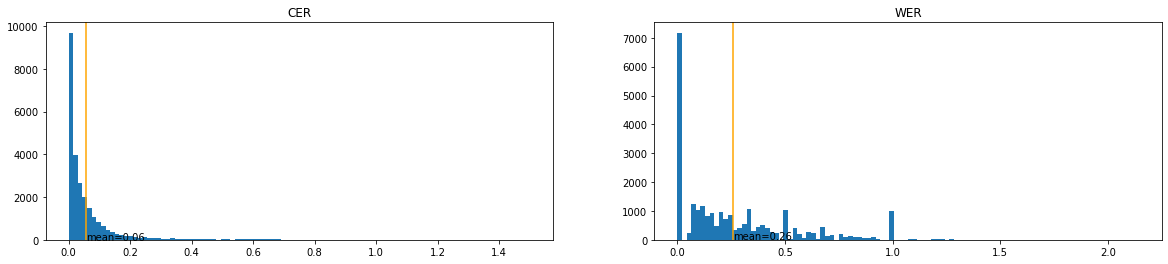

In [19]:
plot_cer_wer(cers, wers, path=f'{model_name}/{timestamp}.wer-cer.png')

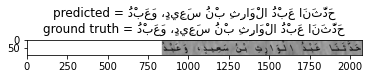

In [20]:
# demo

import arabic_reshaper
from bidi.algorithm import get_display

to_arabic_display = lambda text: get_display(text)
img, label = random.choice(val_dataset)
img, _, _ = dataloader.collate_fn([[img, label]])

gt = (''.join([PEGON_CHARS[l] for l in filter(lambda x:x!= 0, label)]))

predicted = decoder.infer(img.cuda())[0]

tensor_to_display = lambda x : transforms.ToPILImage()(transforms.RandomHorizontalFlip(p=1)(x))

plt.imshow(tensor_to_display(img[0]), cmap='gray'); plt.title(f'predicted = {to_arabic_display(predicted)}\nground truth = {to_arabic_display(gt)}'); plt.show()

In [21]:
import importlib
import pegon_utils
importlib.reload(pegon_utils)
from pegon_utils import FilenameOCRDataset, PegonAnnotatedDataset, ctc_collate_fn
import pdb

annotated_dataset = PegonAnnotatedDataset('/workspace/Dataset/pegon-annotated-dataset-split-v3',
                                          image_transform=dataset_transforms)

annotated_dataloader = DataLoader(annotated_dataset, shuffle=True,
                                  batch_size=4,
                                  num_workers=2,
                                  collate_fn=ctc_collate_fn)
cers, wers = evaluate(decoder, annotated_dataloader)

  0%|          | 0/1028 [00:00<?, ?it/s]

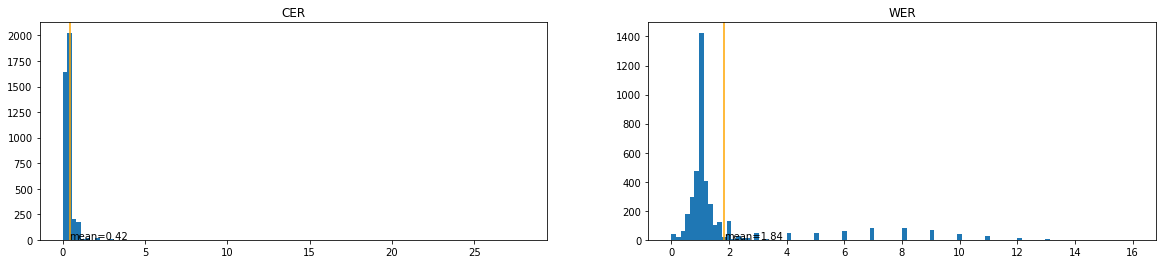

In [22]:
plot_cer_wer(cers, wers, path=f'{model_name}/{timestamp}.eval.wer-cer.png')

/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


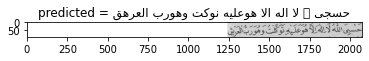

In [23]:
# demo

import arabic_reshaper
from bidi.algorithm import get_display

to_arabic_display = lambda text: get_display(arabic_reshaper.reshape(text))
img, label, _ = dataloader.collate_fn([random.choice(annotated_dataset)])

predicted = decoder.infer(img.cuda())[0]

tensor_to_display = lambda x : transforms.ToPILImage()(transforms.RandomHorizontalFlip(p=1)(x))

plt.imshow(tensor_to_display(img[0]),cmap='gray'); plt.title(f'predicted = {to_arabic_display(predicted)}'); plt.show()